In [ ]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import DataLoader, Dataset,Subset
from torchvision import transforms , datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import timm
from sklearn.metrics import f1_score, accuracy_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print(os.listdir('/content/drive/My Drive/Colab Notebooks/Aerial_Landscapes'))

Mounted at /content/drive
['Airport', 'Agriculture', 'City', 'Beach', 'Desert', 'Forest', 'Highway', 'Grassland', 'Lake', 'Mountain', 'Port', 'Parking', 'Residential', 'Railway', 'River']


In [ ]:
img_path ='/content/drive/My Drive/Colab Notebooks/Aerial_Landscapes'

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


dataset_path = img_path


dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

print("类别名称:", dataset.classes)
print("数据集大小:", len(dataset))

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())
torch.cuda.empty_cache()



类别名称: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
数据集大小: 12000
Tesla T4


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:

indices = np.arange(len(dataset))

y = np.array(dataset.targets)


train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y)
print("train data:", len(train_idx))
print("test data:", len(test_idx))


train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(dataset.classes)
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
model = model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}")

    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    print("=== Classification Report ===")
    print(classification_report(
        y_true,
        y_pred,
        target_names=dataset.classes,
        digits=4
    ))

训练集样本数: 9600
测试集样本数: 2400


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1: 100%|██████████| 300/300 [00:56<00:00,  5.27it/s]

Epoch 1/10 - Loss: 0.4906


Test Accuracy: 0.9408
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9671    0.9187    0.9423       160
     Airport     0.9346    0.8938    0.9137       160
       Beach     0.9244    0.9938    0.9578       160
        City     0.9455    0.9750    0.9600       160
      Desert     0.9608    0.9187    0.9393       160
      Forest     0.9675    0.9313    0.9490       160
   Grassland     0.9235    0.9812    0.9515       160
     Highway     0.9850    0.8187    0.8942       160
        Lake     0.9603    0.9062    0.9325       160
    Mountain     0.9728    0.8938    0.9316       160
     Parking     0.9349    0.9875    0.9605       160
        Port     0.9811    0.9750    0.9781       160
     Railway     0.8112    0.9938    0.8933       160
 Residential     0.9815    0.9938    0.9876       160
       River     0.9085    0.9313    0.9198       160

    accuracy                         0.9408      2400
   macro avg     0.9439    0

Epoch 2:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2: 100%|██████████| 300/300 [00:57<00:00,  5.18it/s]

Epoch 2/10 - Loss: 0.1741


Test Accuracy: 0.9463
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9444    0.9563    0.9503       160
     Airport     0.9494    0.9375    0.9434       160
       Beach     0.9693    0.9875    0.9783       160
        City     0.8541    0.9875    0.9159       160
      Desert     0.9865    0.9125    0.9481       160
      Forest     0.9796    0.9000    0.9381       160
   Grassland     0.8870    0.9812    0.9318       160
     Highway     0.9812    0.9812    0.9812       160
        Lake     0.9655    0.8750    0.9180       160
    Mountain     0.9317    0.9375    0.9346       160
     Parking     0.9576    0.9875    0.9723       160
        Port     0.9737    0.9250    0.9487       160
     Railway     0.9796    0.9000    0.9381       160
 Residential     0.9815    0.9938    0.9876       160
       River     0.8869    0.9313    0.9085       160

    accuracy                         0.9463      2400
   macro avg     0.9485    0

Epoch 3:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3: 100%|██████████| 300/300 [00:57<00:00,  5.17it/s]

Epoch 3/10 - Loss: 0.1436


Test Accuracy: 0.9546
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9929    0.8750    0.9302       160
     Airport     0.9390    0.9625    0.9506       160
       Beach     0.9568    0.9688    0.9627       160
        City     0.9744    0.9500    0.9620       160
      Desert     0.9029    0.9875    0.9433       160
      Forest     0.9875    0.9875    0.9875       160
   Grassland     0.9390    0.9625    0.9506       160
     Highway     0.9565    0.9625    0.9595       160
        Lake     0.9325    0.9500    0.9412       160
    Mountain     0.9724    0.8812    0.9246       160
     Parking     1.0000    0.9625    0.9809       160
        Port     0.9688    0.9688    0.9688       160
     Railway     0.9226    0.9688    0.9451       160
 Residential     0.9755    0.9938    0.9845       160
       River     0.9146    0.9375    0.9259       160

    accuracy                         0.9546      2400
   macro avg     0.9557    0

Epoch 4:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4: 100%|██████████| 300/300 [00:56<00:00,  5.31it/s]

Epoch 4/10 - Loss: 0.0892


Test Accuracy: 0.9592
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9390    0.9625    0.9506       160
     Airport     0.9490    0.9313    0.9401       160
       Beach     0.9695    0.9938    0.9815       160
        City     0.9506    0.9625    0.9565       160
      Desert     0.9747    0.9625    0.9686       160
      Forest     0.9390    0.9625    0.9506       160
   Grassland     0.9623    0.9563    0.9592       160
     Highway     0.9873    0.9688    0.9779       160
        Lake     0.9551    0.9313    0.9430       160
    Mountain     0.9679    0.9437    0.9557       160
     Parking     1.0000    0.9750    0.9873       160
        Port     0.9686    0.9625    0.9655       160
     Railway     0.9345    0.9812    0.9573       160
 Residential     0.9936    0.9688    0.9810       160
       River     0.9024    0.9250    0.9136       160

    accuracy                         0.9592      2400
   macro avg     0.9596    0

Epoch 5:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5: 100%|██████████| 300/300 [00:57<00:00,  5.21it/s]

Epoch 5/10 - Loss: 0.1014


Test Accuracy: 0.9658
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9686    0.9625    0.9655       160
     Airport     0.9277    0.9625    0.9448       160
       Beach     0.9871    0.9563    0.9714       160
        City     0.9808    0.9563    0.9684       160
      Desert     0.9506    0.9625    0.9565       160
      Forest     0.9405    0.9875    0.9634       160
   Grassland     0.9671    0.9187    0.9423       160
     Highway     0.9752    0.9812    0.9782       160
        Lake     0.9625    0.9625    0.9625       160
    Mountain     0.9345    0.9812    0.9573       160
     Parking     0.9936    0.9750    0.9842       160
        Port     0.9871    0.9563    0.9714       160
     Railway     0.9752    0.9812    0.9782       160
 Residential     0.9937    0.9812    0.9874       160
       River     0.9506    0.9625    0.9565       160

    accuracy                         0.9658      2400
   macro avg     0.9663    0

Epoch 6:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6: 100%|██████████| 300/300 [00:57<00:00,  5.19it/s]

Epoch 6/10 - Loss: 0.0621


Test Accuracy: 0.9617
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9329    0.9563    0.9444       160
     Airport     0.9437    0.9437    0.9437       160
       Beach     1.0000    0.9812    0.9905       160
        City     0.9667    0.9062    0.9355       160
      Desert     0.9353    0.9938    0.9636       160
      Forest     0.9874    0.9812    0.9843       160
   Grassland     0.9689    0.9750    0.9720       160
     Highway     0.9874    0.9812    0.9843       160
        Lake     0.9231    0.9750    0.9483       160
    Mountain     0.9563    0.9563    0.9563       160
     Parking     0.9693    0.9875    0.9783       160
        Port     0.9636    0.9938    0.9785       160
     Railway     0.9494    0.9375    0.9434       160
 Residential     0.9755    0.9938    0.9845       160
       River     0.9718    0.8625    0.9139       160

    accuracy                         0.9617      2400
   macro avg     0.9621    0

Epoch 7:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7: 100%|██████████| 300/300 [00:57<00:00,  5.18it/s]

Epoch 7/10 - Loss: 0.0761


Test Accuracy: 0.9596
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9349    0.9875    0.9605       160
     Airport     0.9625    0.9625    0.9625       160
       Beach     0.9935    0.9563    0.9745       160
        City     0.9565    0.9625    0.9595       160
      Desert     0.9571    0.9750    0.9659       160
      Forest     0.9686    0.9625    0.9655       160
   Grassland     0.9739    0.9313    0.9521       160
     Highway     0.9313    0.9313    0.9313       160
        Lake     0.9181    0.9812    0.9486       160
    Mountain     0.9390    0.9625    0.9506       160
     Parking     0.9935    0.9563    0.9745       160
        Port     0.9750    0.9750    0.9750       160
     Railway     0.9387    0.9563    0.9474       160
 Residential     0.9874    0.9812    0.9843       160
       River     0.9733    0.9125    0.9419       160

    accuracy                         0.9596      2400
   macro avg     0.9602    0

Epoch 8:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8: 100%|██████████| 300/300 [00:58<00:00,  5.12it/s]

Epoch 8/10 - Loss: 0.0797


Test Accuracy: 0.9567
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9086    0.9938    0.9493       160
     Airport     0.9560    0.9500    0.9530       160
       Beach     0.9753    0.9875    0.9814       160
        City     0.9568    0.9688    0.9627       160
      Desert     0.9928    0.8625    0.9231       160
      Forest     0.9682    0.9500    0.9590       160
   Grassland     0.9691    0.9812    0.9752       160
     Highway     0.9688    0.9688    0.9688       160
        Lake     0.9497    0.9437    0.9467       160
    Mountain     0.8432    0.9750    0.9043       160
     Parking     1.0000    0.9938    0.9969       160
        Port     0.9755    0.9938    0.9845       160
     Railway     0.9573    0.9812    0.9691       160
 Residential     0.9815    0.9938    0.9876       160
       River     0.9773    0.8063    0.8836       160

    accuracy                         0.9567      2400
   macro avg     0.9587    0

Epoch 9:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9: 100%|██████████| 300/300 [00:57<00:00,  5.19it/s]

Epoch 9/10 - Loss: 0.0524


Test Accuracy: 0.9608
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9750    0.9750    0.9750       160
     Airport     0.9679    0.9437    0.9557       160
       Beach     0.9937    0.9812    0.9874       160
        City     0.9573    0.9812    0.9691       160
      Desert     0.9750    0.9750    0.9750       160
      Forest     0.9521    0.9938    0.9725       160
   Grassland     0.9634    0.9875    0.9753       160
     Highway     0.9573    0.9812    0.9691       160
        Lake     0.9434    0.9375    0.9404       160
    Mountain     0.9800    0.9187    0.9484       160
     Parking     0.8827    0.9875    0.9322       160
        Port     0.9858    0.8688    0.9236       160
     Railway     0.9870    0.9500    0.9682       160
 Residential     0.9937    0.9875    0.9906       160
       River     0.9152    0.9437    0.9292       160

    accuracy                         0.9608      2400
   macro avg     0.9620    0

Epoch 10:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10: 100%|██████████| 300/300 [00:56<00:00,  5.27it/s]

Epoch 10/10 - Loss: 0.0602


Test Accuracy: 0.9604
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9181    0.9812    0.9486       160
     Airport     0.9133    0.9875    0.9489       160
       Beach     0.9353    0.9938    0.9636       160
        City     0.9936    0.9688    0.9810       160
      Desert     0.9401    0.9812    0.9602       160
      Forest     0.9571    0.9750    0.9659       160
   Grassland     0.9872    0.9625    0.9747       160
     Highway     0.9625    0.9625    0.9625       160
        Lake     0.9563    0.9563    0.9563       160
    Mountain     0.9796    0.9000    0.9381       160
     Parking     0.9936    0.9688    0.9810       160
        Port     0.9497    0.9437    0.9467       160
     Railway     0.9808    0.9563    0.9684       160
 Residential     0.9874    0.9812    0.9843       160
       River     0.9660    0.8875    0.9251       160

    accuracy                         0.9604      2400
   macro avg     0.9614    0

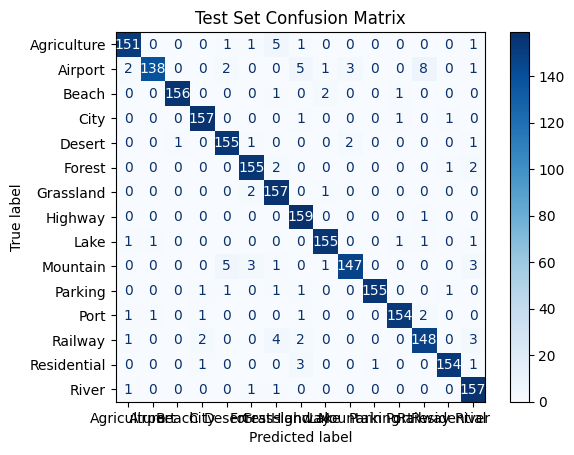

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Set Confusion Matrix")
plt.show()